In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import os
import random
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, 
    OneHotEncoder, LabelEncoder, OrdinalEncoder
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

import category_encoders as ce

from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, 
    GridSearchCV, RandomizedSearchCV
)

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    AdaBoostClassifier, BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, 
    roc_curve, auc
)

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

Loading the raw CSV file, renaming the 'TARGET' column to `Y`. Additionally, verified dataset shape, and checked first few rows to inspect for any missing‐column issues.

In [3]:
# Load dataset from CSV file

file_path = 'project_training_dataset.csv'
data = pd.read_csv(file_path)

# Rename 'TARGET' column to 'Y' (target variable)

data.rename(columns={'TARGET': 'Y'}, inplace=True)

# Separate features and target

feature_cols = [c for c in data.columns if c not in ('SK_ID_CURR', 'Y')]
X = data[feature_cols].copy()
y = data['Y'].copy()

print("Data shape:", data.shape)
imbalance = data['Y'].value_counts(normalize=True) * 100
print(f"Class 0: {imbalance[0]:.4f}%   Class 1: {imbalance[1]:.4f}%")

data.head()

Data shape: (307511, 41)
Class 0: 91.9271%   Class 1: 8.0729%


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,Y
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,Business Entity Type 3,2.0,2.0,-1134.0,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,School,1.0,0.0,-828.0,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,Government,0.0,0.0,-815.0,0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,Business Entity Type 3,2.0,0.0,-617.0,0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,1,1,Religion,0.0,0.0,-1106.0,0


In this preprocessing step, several transformations are applied to clean and prepare the dataset for modeling. Binary categorical features such as `FLAG_OWN_CAR` and `FLAG_OWN_REALTY` are converted from `'Y'` and `'N'` to numeric `1` and `0`, respectively. Invalid entries in the `CODE_GENDER` column (specifically `'XNA'`) are replaced with missing values (`NaN`). For missing occupation information, the category `'Pensioner'` is used as a placeholder, and instances of `'XNA'` in the `ORGANIZATION_TYPE` column are relabeled as `'Retired'`. Additionally, values in the `NAME_FAMILY_STATUS` column are standardized by merging `'marriage'` and `'civil marriage'` into a single `'married'` category. Rows with unusual or unhelpful values in `NAME_TYPE_SUITE` such as `'Other_A'` or `'Other_B'` are removed to reduce noise in the data. The target variable `y` is then reindexed to align with the cleaned feature set `X`.

To reduce the cardinality of high-cardinality categorical features, only the ten most frequent values in the `ORGANIZATION_TYPE` and `OCCUPATION_TYPE` columns are retained. Less common entries are grouped under the label `'Other'`. This helps in minimizing overfitting and controlling the dimensionality of the dataset. Subsequently, categorical variables—including contract type, gender, education level, family status, housing type, occupation, and organization type—are one-hot encoded to convert them into numerical format suitable for machine learning algorithms. The `drop_first=True` parameter is used to prevent multicollinearity by dropping the first level of each categorical variable. Finally, the shapes of the processed feature matrix `X` and the target variable `y` are printed to ensure alignment and completeness before model training.

In [5]:
# Basic preprocessing

X['FLAG_OWN_CAR'] = X['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0}) # Convert 'Y'/'N' values to binary (1/0) in car ownership flag
X['FLAG_OWN_REALTY'] = X['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0}) # Convert 'Y'/'N' values to binary (1/0) in real estate ownership flag
X['CODE_GENDER'] = X['CODE_GENDER'].replace('XNA', np.nan) # Replace invalid gender entry 'XNA' with NaN (missing value)
X['OCCUPATION_TYPE'] = X['OCCUPATION_TYPE'].fillna('Pensioner') # Fill missing values in occupation with 'Pensioner'
X['ORGANIZATION_TYPE'] = X['ORGANIZATION_TYPE'].replace({'XNA': 'Retired'}) # Replace 'XNA' in organization type with a more meaningful label 'Retired'
X['NAME_FAMILY_STATUS'] = X['NAME_FAMILY_STATUS'].replace({'marriage': 'married', 'civil marriage': 'married'}) # Normalize family status labels by merging similar values into 'married'
X = X[~X['NAME_TYPE_SUITE'].isin(['Other_A', 'Other_B'])].reset_index(drop=True) # Remove rows where NAME_TYPE_SUITE is either 'Other_A' or 'Other_B' (uninformative)

y = y.loc[X.index]  # Align target 'y' with filtered data 'X'

# Limit cardinality

top_industry = X['ORGANIZATION_TYPE'].value_counts().nlargest(10).index # Keep only the top 10 most common organization types; label the rest as 'Other'
top_occupation = X['OCCUPATION_TYPE'].value_counts().nlargest(10).index # Keep only the top 10 most common occupation types; label the rest as 'Other'

X['ORGANIZATION_TYPE'] = X['ORGANIZATION_TYPE'].where(X['ORGANIZATION_TYPE'].isin(top_industry), 'Other')
X['OCCUPATION_TYPE'] = X['OCCUPATION_TYPE'].where(X['OCCUPATION_TYPE'].isin(top_occupation), 'Other')

# One-hot encoding

categorical_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE'] # List of categorical columns to encode
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True) # Convert categorical variables into dummy/indicator variables, dropping the first to avoid multicollinearity

print("Shapes:", X.shape, y.shape) # Print the shapes of features and target to confirm alignment

Shapes: (304875, 70) (304875,)


This section creates a set of engineered features to enrich the dataset with more informative signals relevant to creditworthiness and default risk. Several domain-inspired features are calculated using existing columns. For instance, `DEVICE_SCORE` is computed by summing binary indicators of car and real estate ownership, acting as a proxy for economic status. `SIM_STABILITY_YEARS`, derived from the number of days since the last phone change, reflects how stable a borrower’s contact number is, which may correlate with trustworthiness. `CONTACT_DEPTH` aggregates multiple contact flags (such as having a phone, work phone, or email), indicating how reachable and verifiable the individual is.

Additional features include `ID_CHANGE_YEARS` (to capture how recently an ID was issued), `REG_STABILITY_YEARS` (years since address registration), `AGE`, `EMPLOYMENT_YEARS`, and their ratio in `STABILITY_RATIO`, which together signal personal and financial stability. Several financial ratios are also introduced, including `INCOME_ANN_RATIO`, `LOAN_TO_PURCHASE_RATIO`, and `INCOME_TO_CREDIT_RATIO`, which measure a borrower’s repayment ability. A `MOBILITY_INDEX` is calculated based on population density to assess regional risk, and `REGION_QUALITY_SCORE` combines regional client ratings to reflect socio-economic context. To capture geographic inconsistencies that may indicate fraud risk, `ADDRESS_INCONSISTENCY_SCORE` sums several mismatch flags. Lastly, `SOCIAL_DEFAULT_RATIO` evaluates the proportion of defaults within a borrower's social circle.

After defining these engineered features, a final feature set is compiled, including selected raw continuous variables (such as income and credit amount) and one-hot encoded categorical variables. The final dataset is then cleaned by replacing infinite values and clipping extreme outliers at the 1st and 99th percentiles for numerical stability in downstream modeling.

In [7]:
# Feature Engineering

# List of boolean flags indicating mismatches between registration, living, and working regions/cities
address_mismatch_flags = ['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']

X['DEVICE_SCORE'] = X['FLAG_OWN_CAR'] + X['FLAG_OWN_REALTY'] # Device-based Proxy (Owning car/house = higher-end phone = richer data user)
X['SIM_STABILITY_YEARS'] = abs(X['DAYS_LAST_PHONE_CHANGE']) / 365 # Sim Stability Proxy (More years = stable number → less risk)
X['CONTACT_DEPTH'] = X['FLAG_PHONE'] + X['FLAG_WORK_PHONE'] + X['FLAG_MOBIL'] + X['FLAG_EMAIL'] + X['FLAG_CONT_MOBILE'] # More contact depth = reachable = trustable
X['ID_CHANGE_YEARS'] = abs(X['DAYS_ID_PUBLISH']) / 365 # More recent ID → can signal instability
X['MOBILITY_INDEX'] = 1 / (X['REGION_POPULATION_RELATIVE'] + 1e-4) # Mobility Proxy (If person lives in a dense region, less mobile → less risk)
X['REG_STABILITY_YEARS'] = abs(X['DAYS_REGISTRATION']) / 365 # GPS-based Proxy (If someone has a stable address for years → more trustworthy borrower)
X['DEPENDENCY_RATIO'] = X['CNT_CHILDREN'] / (X['CNT_FAM_MEMBERS'] + 1e-4) # More dependents → higher financial stress → greater default risk
X['AGE'] = abs(X['DAYS_BIRTH']) / 365 # Age in years (Young borrowers usually riskier)
X['EMPLOYMENT_YEARS'] = abs(X['DAYS_EMPLOYED']) / 365 # Steady job → better repayment chances
X['STABILITY_RATIO'] = X['EMPLOYMENT_YEARS'] / X['AGE'] # Stability Ratio (Older + stable = reliable)
X['INCOME_ANN_RATIO'] = X['AMT_INCOME_TOTAL'] / X['AMT_ANNUITY'] # Can they afford installments relative to income?
X['LOAN_TO_PURCHASE_RATIO'] = X['AMT_CREDIT'] / X['AMT_GOODS_PRICE'] # Are they over-borrowing or just financing a simple purchase?
X['INCOME_TO_CREDIT_RATIO'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT'] # Proxy for repayment power
X['REGION_QUALITY_SCORE'] = (4 - X['REGION_RATING_CLIENT'] + 4 - X['REGION_RATING_CLIENT_W_CITY']) / 2 # Better area = lower default rates
X['ADDRESS_INCONSISTENCY_SCORE'] = X[address_mismatch_flags].sum(axis=1) # Frequent mismatches make defaulters hard to trace, increasing evasion risk
X['SOCIAL_DEFAULT_RATIO'] = X['DEF_30_CNT_SOCIAL_CIRCLE'] / (X['OBS_30_CNT_SOCIAL_CIRCLE'] + 1e-4) # If contacts default, applicant might too

# Collecting newly engineered features for final dataset
engineered_cols = [
    'DEVICE_SCORE', 'SIM_STABILITY_YEARS', 'CONTACT_DEPTH', 'ID_CHANGE_YEARS',
    'MOBILITY_INDEX', 'REG_STABILITY_YEARS', 'DEPENDENCY_RATIO', 'AGE', 'EMPLOYMENT_YEARS',
    'STABILITY_RATIO', 'INCOME_ANN_RATIO', 'LOAN_TO_PURCHASE_RATIO',
    'INCOME_TO_CREDIT_RATIO', 'REGION_QUALITY_SCORE', 'ADDRESS_INCONSISTENCY_SCORE',
    'SOCIAL_DEFAULT_RATIO'
]

# Select raw financial columns to include in the final dataset
continuous_raw_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

onehot_prefixes = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
onehot_cols = [col for col in X.columns if any(col.startswith(prefix + '_') for prefix in onehot_prefixes)]

final_features = engineered_cols + continuous_raw_cols + onehot_cols # Final feature list includes engineered features, raw numeric values, and one-hot encoded categories
X_final = X[final_features].copy() # Create a copy of the final features subset

# Clean infinite values and clip outliers
clipping_cols = engineered_cols + continuous_raw_cols
for col in clipping_cols:
    X_final[col] = X_final[col].replace([np.inf, -np.inf], np.nan) # Replace infinite values with NaN
    low, high = X_final[col].quantile([0.01, 0.99]) # Clip extreme outliers at 1st and 99th percentiles
    X_final[col] = X_final[col].clip(low, high)

CLASS DISTRIBUTION PLOT

This code visualizes how many instances belong to each class in the target variable y. It's a quick way to check for class imbalance, which is especially important in classification tasks like loan default prediction.

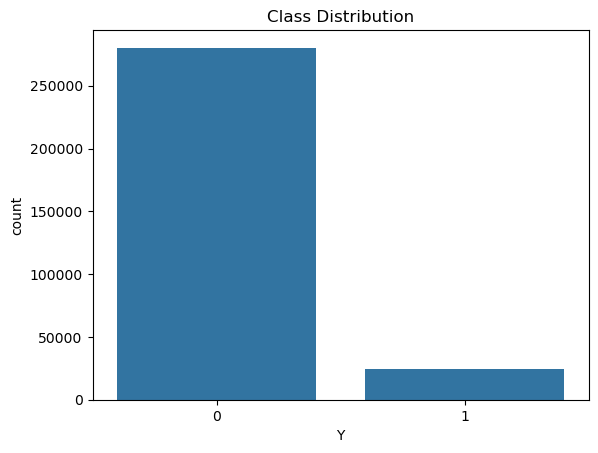

In [9]:
sns.countplot(x=y) # Plot the distribution of target classes (e.g., default vs. non-default)
plt.title("Class Distribution") # Set the title of the plot
plt.show() # Display the plot

DEFAULT RATE BY INCOME BRACKET

In this analysis, the dataset is first combined with the target variable `y` to form a unified DataFrame. The `AMT_INCOME_TOTAL` column is then segmented into five distinct income brackets: `<=50K`, `50K–80K`, `80K–110K`, `110K–140K`, and `140K+`. This binning allows us to observe how default rates vary across different levels of income.

The data is grouped by these income bins, and for each bin, the total number of cases and the number of defaulters are calculated. The default rate is derived by dividing the number of defaulters by the total observations in each bracket.

Finally, the default rates are visualized using a bar plot. This provides an intuitive understanding of whether lower or higher income brackets are associated with higher credit risk, which can inform feature selection or risk stratification strategies in modeling.

/var/folders/34/bmsn7k396bl5cpxzsgjyn1h40000gn/T/ipykernel_53425/3778022344.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = X_copy.groupby('INCOME_BIN')['Y'].agg(['count', 'sum']).reset_index() # Group data by income bin and calculate total observations and number of defaulters


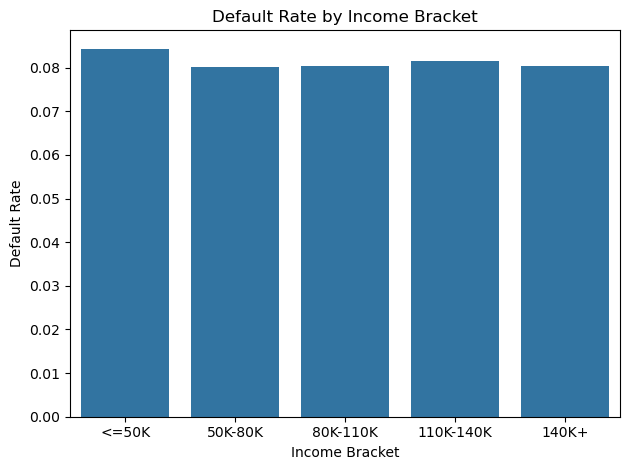

In [11]:
# Combine features and target variable into a single DataFrame for easier analysis
X_copy = X.copy()
X_copy['Y'] = y

# Create income brackets by binning the income variable into defined ranges
X_copy['INCOME_BIN'] = pd.cut(
    X_copy['AMT_INCOME_TOTAL'],
    bins=[0, 50000, 80000, 110000, 140000, float('inf')],
    labels=['<=50K', '50K-80K', '80K-110K', '110K-140K', '140K+'] # Corresponding labels
)

defaulters = X_copy[X_copy['Y'] == 1] # Filter defaulters

grouped = X_copy.groupby('INCOME_BIN')['Y'].agg(['count', 'sum']).reset_index() # Group data by income bin and calculate total observations and number of defaulters
grouped['Default_Rate'] = grouped['sum'] / grouped['count'] # Calculate default rate as sum (defaults) divided by count (total in bin)

# Add plot title and axis labels
sns.barplot(data=grouped, x='INCOME_BIN', y='Default_Rate')
plt.title('Default Rate by Income Bracket')
plt.xlabel('Income Bracket')
plt.ylabel('Default Rate')
plt.tight_layout() # Ensures labels and titles fit well
plt.show() # Display the plot

DEFAULT RATE BY GENDER

This analysis explores the relationship between gender and loan default risk. First, the dataset is filtered to include only valid gender entries ('M' for male and 'F' for female). The data is then grouped by gender, and the mean of the target variable `Y` is calculated for each group. This mean represents the default rate within each gender category.

The results are visualized using a bar plot, showing the proportion of defaulters among male and female applicants. This visualization helps identify whether gender plays a significant role in credit risk and may inform fairness-aware modeling practices or feature selection considerations in the predictive pipeline.

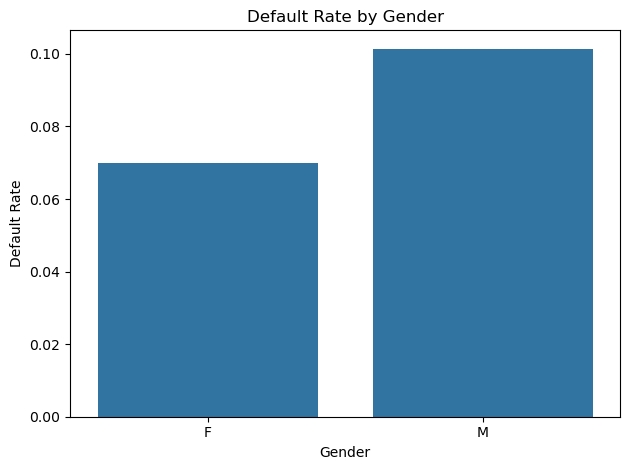

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

eda_df = data.copy() # Make a copy of the original dataset for exploratory data analysis (EDA)
eda_df = eda_df[eda_df['CODE_GENDER'].isin(['M', 'F'])] # Keep only rows where gender is either 'M' (Male) or 'F' (Female)

gender_default_rate = eda_df.groupby('CODE_GENDER')['Y'].mean().reset_index() # Group by gender and calculate the average default rate (mean of target 'Y')

sns.barplot(data=gender_default_rate, x='CODE_GENDER', y='Y') # Plot the default rate by gender using a barplot

# Add plot title and axis labels

plt.title('Default Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Default Rate')

plt.tight_layout() # Adjust layout to prevent clipping of labels
plt.show() # Display the plot

DEFAULT RATE BY DEVICE SCORE

This plot examines how asset ownership, proxied through a `DEVICE_SCORE`, correlates with loan default risk. The `DEVICE_SCORE` is constructed by summing binary indicators for car ownership (`FLAG_OWN_CAR`) and real estate ownership (`FLAG_OWN_REALTY`). Applicants who own neither receive a score of 0, those who own either a car or a house get a 1, and those who own both get a 2.

The default rate is then calculated and visualized for each score group using a bar plot. This helps determine whether asset ownership correlates with financial reliability, as higher asset ownership might indicate stronger economic stability and a lower risk of default.

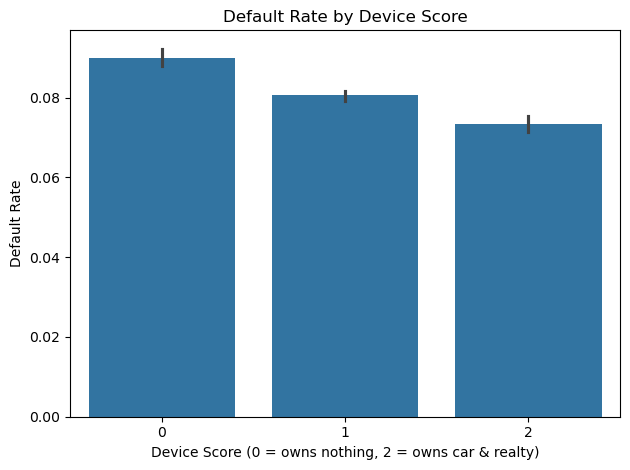

In [15]:
# Create a 'DEVICE_SCORE' feature: sum of binary indicators for car and real estate ownership
# 'Y' is mapped to 1 and 'N' to 0, so the score ranges from 0 (owns nothing, 1 (owns one of the two) to 2 (owns both)

eda_df['DEVICE_SCORE'] = eda_df['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0}) + eda_df['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})

sns.barplot(data=eda_df, x='DEVICE_SCORE', y='Y') # Plot the average default rate (Y) for each device score category (0, 1, 2)

# Add title and axis labels to the plot

plt.title('Default Rate by Device Score')
plt.xlabel('Device Score (0 = owns nothing, 2 = owns car & realty)')
plt.ylabel('Default Rate')

plt.tight_layout() # Optimize layout
plt.show() # Display the plot

DEFAULT RATE BY REGION QUALITY

This analysis investigates whether the perceived quality of a borrower's residential region influences their likelihood of default. A new feature called `REGION_QUALITY_SCORE` is constructed by inverting the existing `REGION_RATING_CLIENT` and `REGION_RATING_CLIENT_W_CITY` values (which typically range from 1 to 3, with 3 being best). By subtracting these ratings from 4 and averaging the two, we create a score where higher values represent poorer region quality.

The resulting `REGION_QUALITY_SCORE` is then plotted against the default rate using a bar plot. This helps assess whether living in lower-rated regions correlates with higher default risk, providing insight into the geographical risk profile of applicants.

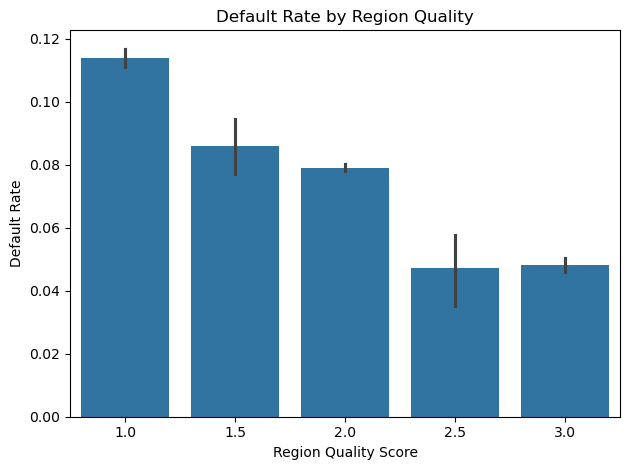

In [17]:
eda_df['REGION_QUALITY_SCORE'] = (4 - eda_df['REGION_RATING_CLIENT'] + 4 - eda_df['REGION_RATING_CLIENT_W_CITY']) / 2

sns.barplot(data=eda_df, x='REGION_QUALITY_SCORE', y='Y')
plt.title('Default Rate by Region Quality')
plt.xlabel('Region Quality Score')
plt.ylabel('Default Rate')
plt.tight_layout()
plt.show()

DEFAULT RATE BY AGE GROUP

This analysis explores the relationship between a borrower's age and their likelihood of default. The `DAYS_BIRTH` column, which represents age in negative days, is converted into a positive age in years. Borrowers are then segmented into age bins: 20–30, 30–40, 40–50, 50–60, and 60–70.

A bar plot is generated to show the average default rate (`Y`) within each age group. This visualization helps identify age-related risk patterns and can reveal whether certain age segments are more prone to default, offering useful guidance for credit risk modeling.

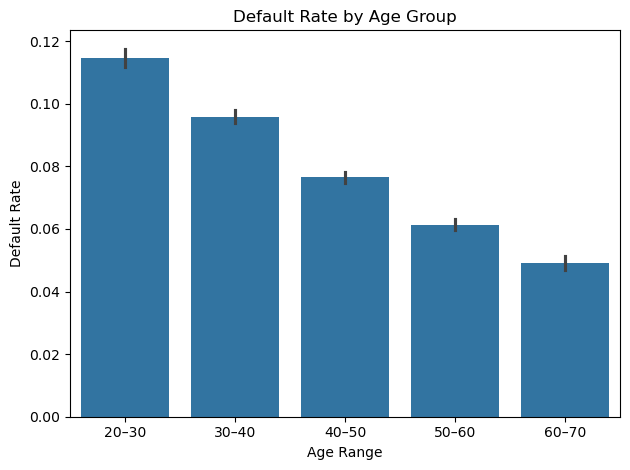

In [19]:
eda_df['AGE'] = abs(eda_df['DAYS_BIRTH']) / 365 # Convert age from days to years using absolute value
eda_df['AGE_BIN'] = pd.cut(eda_df['AGE'], bins=[20, 30, 40, 50, 60, 70], labels=['20–30', '30–40', '40–50', '50–60', '60–70']) # Bin age into groups: 20–30, 30–40, 40–50, 50–60, and 60–70

sns.barplot(data=eda_df, x='AGE_BIN', y='Y')
plt.title('Default Rate by Age Group')
plt.xlabel('Age Range')
plt.ylabel('Default Rate')
plt.tight_layout()
plt.show()

DEFAULT RATE BY DEPENDENCY RATIO

This analysis investigates the effect of household dependency on loan default risk. A new feature, `DEPENDENCY_RATIO`, is calculated by dividing the number of children (`CNT_CHILDREN`) by the total number of family members (`CNT_FAM_MEMBERS`). A small constant is added to the denominator to prevent division errors.

The dependency ratio is then segmented into five bins: 0–20%, 21–40%, 41–60%, 61–80%, and 81–100%, representing increasing levels of financial burden within a household. A bar plot is used to visualize the average default rate in each bin, helping to determine whether higher dependency correlates with a greater likelihood of default. This can inform risk scoring and model features related to household structure.

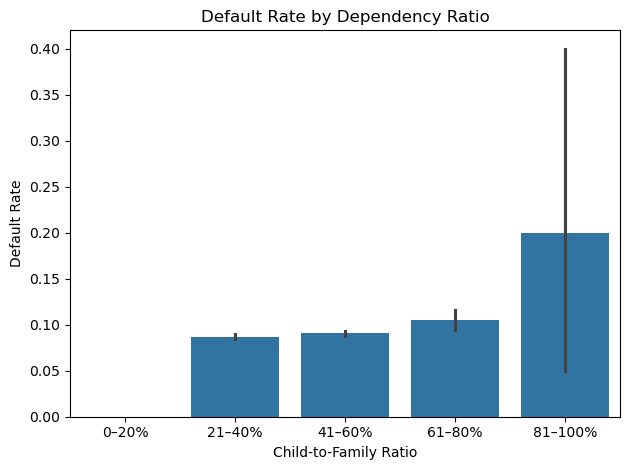

In [21]:
eda_df['DEPENDENCY_RATIO'] = eda_df['CNT_CHILDREN'] / (eda_df['CNT_FAM_MEMBERS'] + 1e-4) # Calculate the dependency ratio: number of children divided by total family members

eda_df['DEPENDENCY_BIN'] = pd.cut(
    eda_df['DEPENDENCY_RATIO'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['0–20%', '21–40%', '41–60%', '61–80%', '81–100%']
)

# Plot

sns.barplot(data=eda_df, x='DEPENDENCY_BIN', y='Y')
plt.title('Default Rate by Dependency Ratio')
plt.xlabel('Child-to-Family Ratio')
plt.ylabel('Default Rate')
plt.tight_layout()
plt.show()

DEFAULT RATE BY ORGANIZATION TYPE

This analysis explores how default rates vary across different types of employers. To keep the analysis focused and readable, only the top 10 most frequent `ORGANIZATION_TYPE` categories are considered. The dataset is filtered accordingly, and the average default rate (`Y`) is calculated for each of these categories.

A horizontal bar plot is used to visualize the default rates, providing insights into which types of organizations are associated with higher or lower credit risk. This can be useful for feature selection and for assessing the potential impact of employment type on loan repayment behavior.

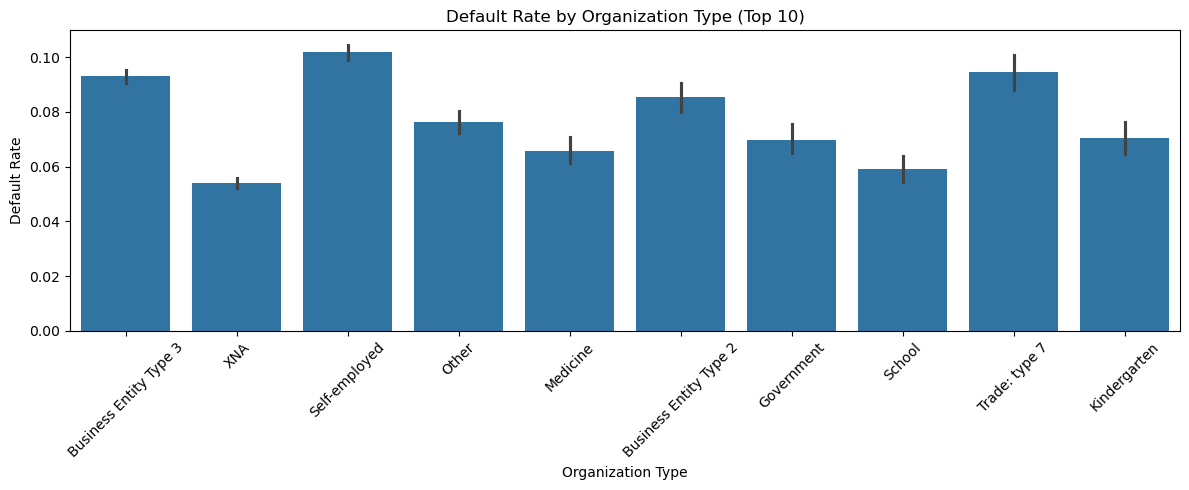

In [23]:
top_orgs = eda_df['ORGANIZATION_TYPE'].value_counts().nlargest(10).index # Top 10 most frequent organization types
org_df = eda_df[eda_df['ORGANIZATION_TYPE'].isin(top_orgs)] # Filter only top 10

# Plot

plt.figure(figsize=(12, 5))
sns.barplot(data=org_df, x='ORGANIZATION_TYPE', y='Y', order=top_orgs)
plt.xticks(rotation=45)
plt.title('Default Rate by Organization Type (Top 10)')
plt.xlabel('Organization Type')
plt.ylabel('Default Rate')
plt.tight_layout()
plt.show()

DEFAULT RATE BY OCCUPATION TYPE

This plot analyzes the relationship between a borrower's occupation type and their likelihood of default. To focus on the most significant categories, the top 10 most frequent `OCCUPATION_TYPE` entries are selected. The dataset is filtered accordingly, and the default rate (`Y`) is computed for each occupation group.

The resulting bar plot helps visualize which professions are more prone to loan default. This can be particularly insightful for risk modeling, as certain occupations may correlate with more stable income streams and therefore lower credit risk.

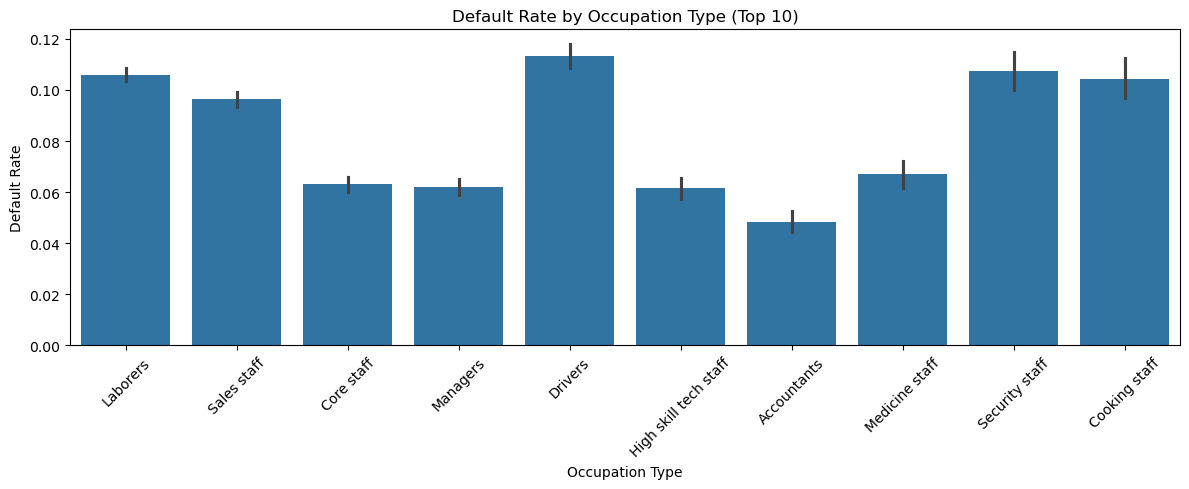

In [25]:
top_occs = eda_df['OCCUPATION_TYPE'].value_counts().nlargest(10).index # Top 10 most frequent occupation types
occ_df = eda_df[eda_df['OCCUPATION_TYPE'].isin(top_occs)] # Filter only top 10

# Plot

plt.figure(figsize=(12, 5))
sns.barplot(data=occ_df, x='OCCUPATION_TYPE', y='Y', order=top_occs)
plt.xticks(rotation=45)
plt.title('Default Rate by Occupation Type (Top 10)')
plt.xlabel('Occupation Type')
plt.ylabel('Default Rate')
plt.tight_layout()
plt.show()

CORRELATION OF FINAL NUMERIC FEATURES WITH DEFAULT FLAG

To assess the predictive strength of each engineered feature, we compute their correlation with the target variable `Y`. Before doing so, the target is realigned to match the shape of the final feature set (`X_final`). One-hot encoded categorical variables are excluded from this analysis to avoid redundancy and clutter.

A correlation matrix is computed using Pearson correlation, and the features are sorted based on the absolute correlation values with `Y`. This helps identify which continuous or engineered features are most strongly associated with default behavior.

The correlations are then visualized as a horizontal bar chart. Positive correlations suggest that higher feature values increase the likelihood of default, while negative correlations imply a protective effect. This analysis is crucial for understanding feature relevance before model training.

Y                              1.000000
MOBILITY_INDEX                -0.006416
REGION_QUALITY_SCORE           0.004743
DEVICE_SCORE                   0.002930
SIM_STABILITY_YEARS            0.002627
AMT_GOODS_PRICE                0.001476
AMT_CREDIT                     0.001446
LOAN_TO_PURCHASE_RATIO        -0.001290
SOCIAL_DEFAULT_RATIO           0.001148
ADDRESS_INCONSISTENCY_SCORE    0.001028
AGE                            0.000963
INCOME_ANN_RATIO              -0.000873
DEPENDENCY_RATIO               0.000836
REG_STABILITY_YEARS           -0.000743
INCOME_TO_CREDIT_RATIO        -0.000616
AMT_ANNUITY                    0.000607
AMT_INCOME_TOTAL               0.000560
CONTACT_DEPTH                  0.000415
ID_CHANGE_YEARS                0.000347
EMPLOYMENT_YEARS               0.000181
STABILITY_RATIO                0.000088
Name: Y, dtype: float64


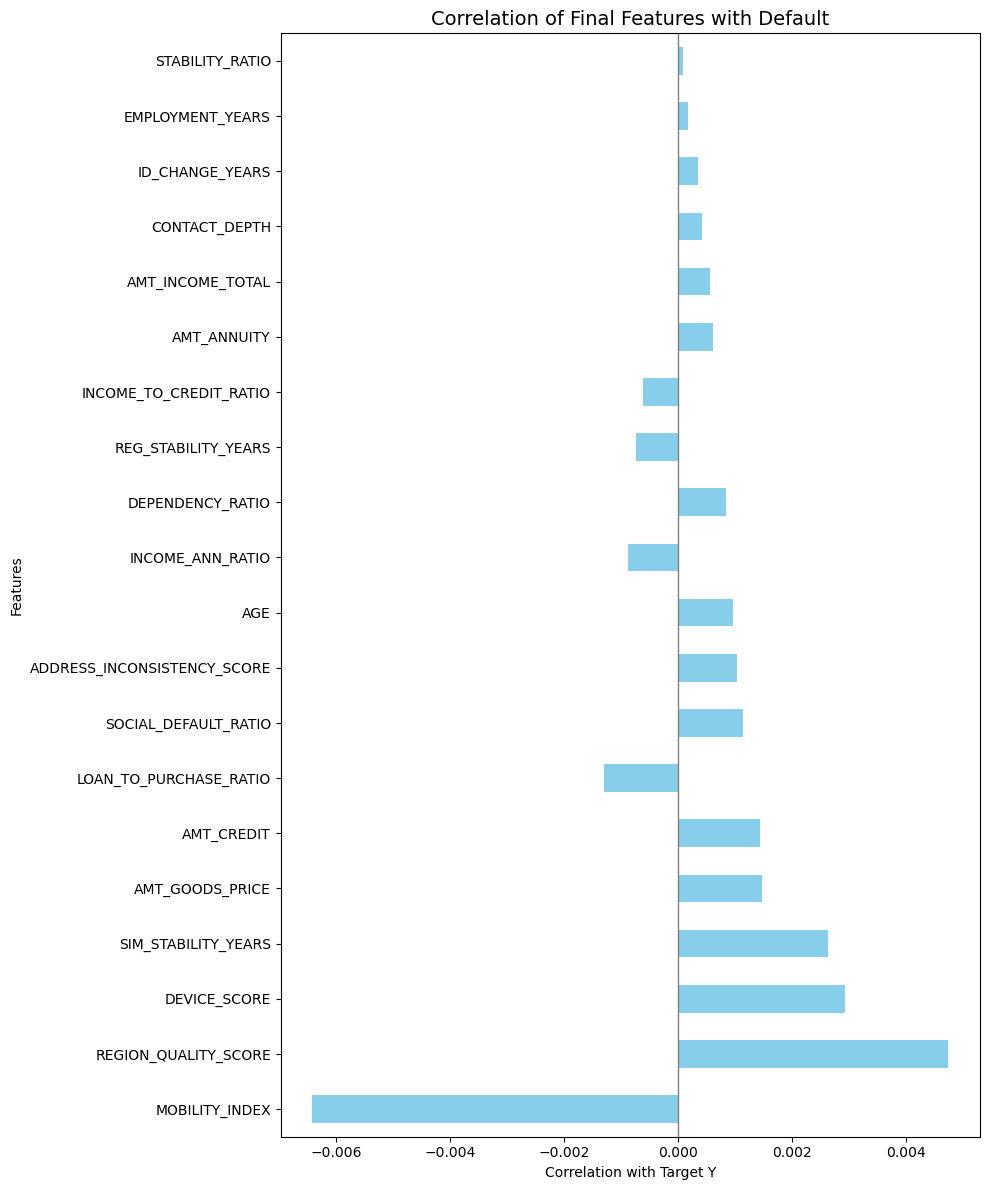

In [27]:
y_aligned = y.iloc[:len(X_final)].reset_index(drop=True) # Align the target variable 'y' with X_final's length and reset index

# Create correlation DataFrame
corr_df = X_final.copy() 
corr_df['Y'] = y_aligned

# Remove one-hot encoded columns from final features
onehot_prefixes = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_TYPE_SUITE', 
                   'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
                   'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

# Remove one-hot columns based on prefix
filtered_features = [f for f in final_features if not any(f.startswith(prefix + '_') for prefix in onehot_prefixes)]

# Add Y back
corr_df = corr_df[filtered_features + ['Y']]

# Compute correlation
corr_with_y = corr_df.corr()['Y'].sort_values(key=abs, ascending=False)

# Show result
print(corr_with_y)

# Plot the correlation values as a horizontal bar chart
corr_with_y.drop('Y').plot(kind='barh', figsize=(10, 12), color='skyblue')
plt.title('Correlation of Final Features with Default', fontsize=14)
plt.xlabel('Correlation with Target Y')
plt.ylabel('Features')
plt.axvline(0, color='gray', linewidth=1)
plt.tight_layout()
plt.show()

The final processed dataset is divided into training and testing sets using an 80/20 split. The `stratify=y` parameter ensures that the distribution of the target variable (`Y`) remains consistent across both the training and test sets, which is especially important for imbalanced classification problems.

A `random_state` value of 42 is used to ensure reproducibility, meaning the same data split can be achieved every time the code is run. This separation of data is crucial for evaluating the model's generalization performance on unseen data.

In [29]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, stratify=y, random_state=42)

This section defines a preprocessing pipeline to transform the numerical features before feeding them into a machine learning model. The columns to be transformed (`clipping_cols`) are assigned to `numeric_cols`.

A `ColumnTransformer` is used to apply transformations only to the specified numerical columns. Inside this, a `Pipeline` first imputes missing values using the median strategy—ideal for skewed distributions—and then standardizes the features using `StandardScaler`, which scales data to have zero mean and unit variance.

This pipeline helps ensure consistent and clean numeric input to the model while preventing data leakage by keeping preprocessing within a fitted pipeline.

In [45]:
numeric_cols = clipping_cols

# Create a preprocessing pipeline for numerical features
preprocess = ColumnTransformer([
    ('num', Pipeline([
        ('imp', SimpleImputer(strategy='median')), # Fill missing values with median
        ('scale', StandardScaler()) # Standardize features
    ]), numeric_cols)
])

The preprocessing pipeline defined earlier is now applied to the data. First, the pipeline is fitted and used to transform the training data (`X_train`) using `fit_transform`. This step learns the parameters (e.g., median values and scaling factors) from the training set only, which prevents data leakage.

Next, the same transformations are applied to the test set (`X_test`) using `transform`. This ensures the test data is processed consistently based on parameters learned from the training data. The resulting `X_train_p` and `X_test_p` matrices are now ready for model training and evaluation.

In [47]:
X_train_p = preprocess.fit_transform(X_train) # Fit the preprocessing pipeline on the training data and transform it
X_test_p = preprocess.transform(X_test) # Apply the same transformation to the test data (without refitting)

**LOGISTIC REGRESSION MODEL**

This section trains a logistic regression model using hyperparameter tuning and a custom classification threshold to handle imbalanced data effectively. A grid search is conducted over different values of the regularization parameter `C` and `class_weight` strategies to find the best model based on cross-validated recall for class 1 (defaulters).

Once the best model is identified, it is used to predict probabilities on the test set. Rather than using the default threshold of 0.5, a threshold sweep is performed using the ROC curve to identify the cutoff that maximizes recall while keeping the false positive rate (FPR) below a specified limit.

The selected threshold is then applied to generate final binary predictions, ensuring a balance between identifying the maximum number of defaulters (high recall) while minimizing false alarms (FPR). This approach is particularly useful in credit risk settings where missing a defaulter is more costly than a few false positives.

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'C': 0.01, 'class_weight': {0: 1, 1: 20}}
Best CV recall₁: 1.0

Chosen threshold = 0.643 → FPR=0.200, TPR=0.207


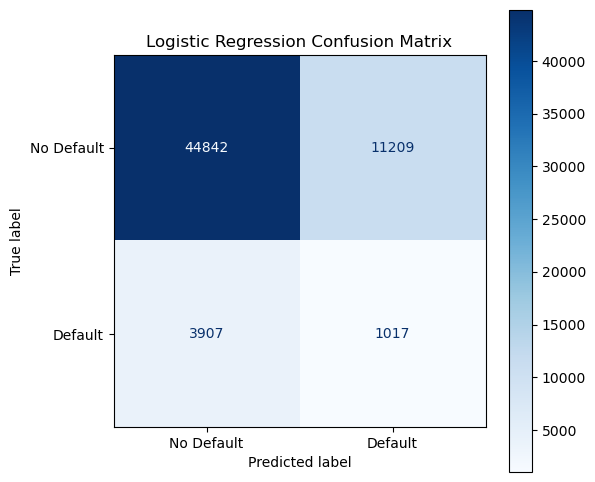

              precision    recall  f1-score   support

  No Default       0.92      0.80      0.86     56051
     Default       0.08      0.21      0.12      4924

    accuracy                           0.75     60975
   macro avg       0.50      0.50      0.49     60975
weighted avg       0.85      0.75      0.80     60975



In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve
)

# Hyperparameter grid search (regularization & class_weight)
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "class_weight": [
        None,
        "balanced",
        {0:1, 1:5},
        {0:1, 1:10},
        {0:1, 1:20},
    ]
}

lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1) # Initialize logistic regression model with max_iter to ensure convergence

# Use GridSearchCV to find best hyperparameters based on recall (for class 1)
grid = GridSearchCV(lr, param_grid, scoring="recall", cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_p, y_train)

print("Best params:", grid.best_params_)
print("Best CV recall₁:", grid.best_score_)

best_lr = grid.best_estimator_ # Extract best logistic regression model

probs = best_lr.predict_proba(X_test_p)[:,1] # Predict probabilities for the positive class (1 = defaulter)

# Sweep a threshold to limit false positives and maximize recall₁
fpr, tpr, thresholds = roc_curve(y_test, probs) # Use ROC curve to calculate TPR and FPR at various thresholds
max_fpr = 0.20 # Set maximum acceptable false positive rate

# Identify the index of the best threshold under FPR constraint
valid = np.where(fpr <= max_fpr)[0]
best_idx = valid[np.argmax(tpr[valid])]
thr = thresholds[best_idx]

print(f"\nChosen threshold = {thr:.3f} → FPR={fpr[best_idx]:.3f}, TPR={tpr[best_idx]:.3f}") # Print selected threshold and corresponding FPR & TPR

y_pred = (probs >= thr).astype(int) # Convert probabilities to binary predictions based on chosen threshold

# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Default","Default"])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=["No Default", "Default"])) # Print classification report

**LIGHTGBM MODEL**

This block trains a LightGBM classifier optimized for imbalanced binary classification. First, the ratio of negative to positive samples in the training data is computed to guide the setting of `scale_pos_weight`, which balances the importance of the minority class (defaulters).

A randomized hyperparameter search is conducted over a range of tree configurations and class weights. The model is evaluated using the F1 score to balance precision and recall, particularly important when false negatives are costly. After training, predicted probabilities are generated and analyzed via an ROC curve. Instead of using a default 0.5 cutoff, a threshold is selected such that the false positive rate (FPR) stays under a specified limit while maximizing the true positive rate (recall).

The model's final performance is visualized using a confusion matrix and detailed in a classification report. 

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/

[LightGBM] [Info] Number of positive: 13132, number of negative: 149468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3398
[LightGBM] [Info] Number of data points in the train set: 162600, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080763 -> initscore=-2.432030
[LightGBM] [Info] Start training from score -2.432030
[LightGBM] [Info] Number of positive: 13132, number of negative: 149468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3402
[LightGBM] [Info] Number of data points in the train set: 162600, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080763 -> initscore=-2.43203

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 13132, number of negative: 149468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3403
[LightGBM] [Info] Number of data points in the train set: 162600, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080763 -> initscore=-2.432030
[LightGBM] [Info] Start training from score -2.432030
[LightGBM] [Info] Number of positive: 13132, number of negative: 149468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3398
[LightGBM] [Info] Number of data points in the train set: 162600, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080763 -> initscore=-2.43203

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Info] Number of data points in the train set: 162600, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080763 -> initscore=-2.432030
[LightGBM] [Info] Start training from score -2.432030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19698, number of negative: 224202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3406
[LightGBM] [Info] Number of data points in the train set: 243900, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080763 -> initscore=-2.432030
[LightGBM] [Info] Start training from score -2.432030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Chosen threshold (FPR≤0.25): 0.6616
 → FPR: 0.250, TPR (Recall₁): 0.256


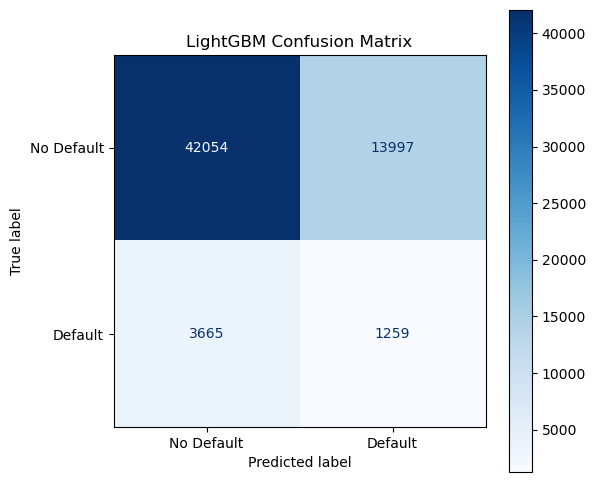

              precision    recall  f1-score   support

           0     0.9198    0.7503    0.8265     56051
           1     0.0825    0.2557    0.1248      4924

    accuracy                         0.7103     60975
   macro avg     0.5012    0.5030    0.4756     60975
weighted avg     0.8522    0.7103    0.7698     60975



In [61]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, confusion_matrix, classification_report


from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import numpy as np

# Compute the ratio of negative to positive samples in the training data
neg, pos = np.bincount(y_train)
base_w = neg / pos

# Set up a LightGBM classifier with a large number of estimators
lgbm = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_estimators=1000,
    n_jobs=-1
)

# Define the hyperparameter space for randomized search, including tree parameters and different scales of positive class weighting
param_dist = {
    'num_leaves':       [31, 50, 100],
    'max_depth':        [-1, 6, 10],
    'learning_rate':    [0.01, 0.03, 0.05],
    'scale_pos_weight': [base_w*0.5, base_w, base_w*2], # Adjust weight to handle class imbalance
}

# Randomized search over the defined parameter space using F1 as scoring
rs = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=15,               # Limit number of combinations to save compute time
    scoring='f1',            # Optimize for F1 score
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)
rs.fit(
    X_train_p, y_train,
    eval_set=[(X_test_p, y_test)],
    eval_metric='auc',
)

# Extract best model and print the best parameters and F1 score
best = rs.best_estimator_
print("Best params:", rs.best_params_)
print("Best CV F1 :", rs.best_score_)

probs = best.predict_proba(X_test_p)[:,1] # Predict the probabilities for class 1 (defaulter) from the trained pipeline

fpr, tpr, thresholds = roc_curve(y_test, probs) # Generate the ROC curve to get False Positive Rates, True Positive Rates, and thresholds
max_fpr = 0.25 # Set a constraint on the maximum acceptable false positive rate (FPR)
valid = np.where(fpr <= max_fpr)[0] # Find all thresholds that satisfy this FPR constraint

# From valid thresholds, pick the one with the highest true positive rate (TPR)
best_idx = valid[np.argmax(tpr[valid])]
chosen_thresh = thresholds[best_idx]

# Print the selected threshold along with corresponding FPR and TPR
print(f"Chosen threshold (FPR≤{max_fpr}): {chosen_thresh:.4f}")
print(f" → FPR: {fpr[best_idx]:.3f}, TPR (Recall₁): {tpr[best_idx]:.3f}")

y_pred = (probs >= chosen_thresh).astype(int) # Use the chosen threshold to convert probabilities into binary predictions

# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default","Default"])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("LightGBM Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, digits=4))

**CATBOOST MODEL**

This section uses a custom pipeline to address class imbalance and train a high-performing classifier using CatBoost. `BorderlineSMOTE` is applied within the pipeline to oversample only borderline cases of the minority class (defaults), which can enhance the model’s focus on difficult-to-classify examples.

The pipeline is tuned using `RandomizedSearchCV` over a defined hyperparameter space. The search is optimized for the F1 score, which balances precision and recall — a crucial metric in imbalanced binary classification problems. After training, the best model is used to predict outcomes on the test set. Performance is evaluated using a confusion matrix and a full classification report, offering insights into the model’s ability to correctly detect defaulters while minimizing false positives.

Fitting 3 folds for each of 30 candidates, totalling 90 fits
0:	learn: 0.6066278	total: 198ms	remaining: 39.4s
2:	learn: 0.6754018	total: 478ms	remaining: 31.4s
4:	learn: 0.6707113	total: 710ms	remaining: 27.7s
6:	learn: 0.6733658	total: 1.01s	remaining: 27.9s
8:	learn: 0.6790949	total: 1.16s	remaining: 24.5s
10:	learn: 0.6774984	total: 1.33s	remaining: 22.9s
12:	learn: 0.6807002	total: 1.51s	remaining: 21.7s
14:	learn: 0.6832554	total: 1.72s	remaining: 21.2s
16:	learn: 0.6795964	total: 1.89s	remaining: 20.4s
18:	learn: 0.6844595	total: 2.18s	remaining: 20.8s
20:	learn: 0.6819919	total: 2.39s	remaining: 20.4s
22:	learn: 0.6873265	total: 2.58s	remaining: 19.9s
24:	learn: 0.6954920	total: 2.8s	remaining: 19.6s
26:	learn: 0.6967487	total: 2.98s	remaining: 19.1s
28:	learn: 0.7092043	total: 3.16s	remaining: 18.6s
30:	learn: 0.7101490	total: 3.33s	remaining: 18.2s
32:	learn: 0.7151027	total: 3.5s	remaining: 17.7s
34:	learn: 0.7158494	total: 3.7s	remaining: 17.4s
36:	learn: 0.7178631	total: 3

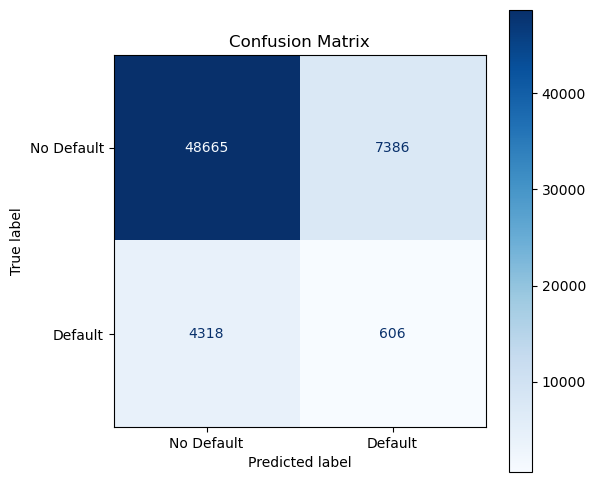

              precision    recall  f1-score   support

           0     0.9185    0.8682    0.8927     56051
           1     0.0758    0.1231    0.0938      4924

    accuracy                         0.8081     60975
   macro avg     0.4972    0.4956    0.4932     60975
weighted avg     0.8505    0.8081    0.8281     60975



In [63]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Create a pipeline that applies BorderlineSMOTE for oversampling before fitting CatBoostClassifier
pipe_cat = ImbPipeline([
    ('sampler', BorderlineSMOTE(random_state=42)), # Handle class imbalance by generating synthetic minority samples
    ('clf', CatBoostClassifier(
        random_state=42,
        verbose=2,
        eval_metric='F1' # Optimize F1 score during training
    ))
])

# Define hyperparameter search space for CatBoost
param_dist_cat = {
    'clf__iterations':    [100, 200, 500, 1000],   # Number of boosting rounds
    'clf__depth':         [4, 6, 8, 10],           # Tree depth
    'clf__learning_rate': [0.01, 0.03, 0.05, 0.1], # Learning rate
    'clf__l2_leaf_reg':   [1, 3, 5, 7, 9]          # L2 regularization
}

# Perform randomized search to find the best hyperparameters
rs_cat = RandomizedSearchCV(
    estimator=pipe_cat,
    param_distributions=param_dist_cat,
    n_iter=30,            # Try 30 different combinations
    scoring='f1',         # optimize for minority-class F1
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

rs_cat.fit(X_train_p, y_train) # Fit the model to the training data (pipeline will automatically apply SMOTE)

best_pipe = rs_cat.best_estimator_ # Retrieve the best estimator from the search

y_pred = best_pipe.predict(X_test_p) # Generate predictions on the test set

# Create and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Default","Default"]
)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", values_format='d', ax=ax)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, digits=4))

**XGBOOST MODEL**

In this section, an XGBoost classifier is trained using a pipeline that includes SMOTEENN, which combines oversampling (SMOTE) and data cleaning (Edited Nearest Neighbors) to handle both class imbalance and noise in the training data. This improves the robustness of the model, particularly for minority class prediction. After fitting the pipeline, predicted probabilities are generated for the test set. Instead of default thresholding, a sweep over 1001 thresholds is performed to find the one that meets a minimum accuracy of 70% while maximizing recall on the defaulting class.

Once the optimal threshold is selected, binary predictions are made, and the model's performance is evaluated using a confusion matrix and a classification report. This approach ensures that the model is not only accurate but also sensitive to detecting defaulters—critical in financial risk applications.

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:43:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Chosen threshold = 0.2710
 → Accuracy = 0.7011, Recall₁ = 0.2571



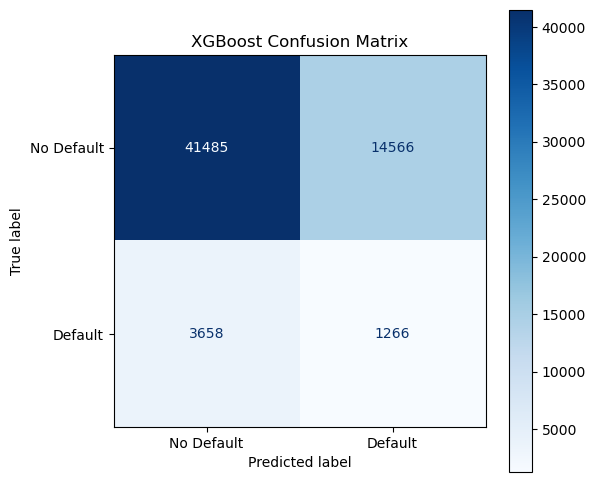

              precision    recall  f1-score   support

           0     0.9190    0.7401    0.8199     56051
           1     0.0800    0.2571    0.1220      4924

    accuracy                         0.7011     60975
   macro avg     0.4995    0.4986    0.4709     60975
weighted avg     0.8512    0.7011    0.7636     60975



In [66]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_curve,
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# Define a pipeline with SMOTEENN (combination of oversampling + cleaning) and XGBoost

pipe_xg = ImbPipeline([
    ("smoteenn", SMOTEENN(random_state=42)), # Handles imbalance + noise
    ("xgb", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    ))
])

pipe_xg.fit(X_train_p, y_train) # Train the pipeline on preprocessed training data

probs_xg = pipe_xg.predict_proba(X_test_p)[:,1] # Get predicted probabilities for the positive class

thresholds_xg = np.linspace(0, 1, 1001) # Define thresholds from 0 to 1 in small steps
best_xg = {'thr': None, 'recall1': 0.0, 'accuracy': 0.0} # Initialize dictionary to store best threshold metrics

# Loop over thresholds to find the one that meets accuracy ≥ 70% and maximizes recall₁
for thr in thresholds_xg:
    y_pred_xg = (probs_xg >= thr).astype(int)
    acc  = accuracy_score(y_test, y_pred_xg)
    rec1 = recall_score(y_test, y_pred_xg, pos_label=1)
    if acc >= 0.70 and rec1 > best_xg['recall1']:
        best_xg.update({'thr': thr, 'recall1': rec1, 'accuracy': acc})

# If no valid threshold is found, raise an error
if best_xg['thr'] is None:
    raise RuntimeError("No threshold achieves ≥70% accuracy")

# Use the chosen threshold to get final predictions
thr = best_xg['thr']
y_pred_xg = (probs_xg >= thr).astype(int)

print(f"Chosen threshold = {thr:.4f}")
print(f" → Accuracy = {best_xg['accuracy']:.4f}, Recall₁ = {best_xg['recall1']:.4f}\n")

# Generate and display the confusion matrix
cm_xg = confusion_matrix(y_test, y_pred_xg)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_xg,
    display_labels=["No Default","Default"]
)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("XGBoost Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_xg, digits=4))

**RUBOOST MODEL**

This block implements a RUSBoost model, which combines boosting with random undersampling to address class imbalance. A `DecisionTreeClassifier` is used as the base estimator, with increased class weights for defaulters to prioritize their identification during training.

Training is performed using sample weights to further emphasize the minority class. After predicting probabilities, the code searches for a custom classification threshold that achieves at least 70% accuracy while maximizing true positives (i.e., recall on defaulters). If multiple thresholds yield the same number of true positives, the one with the fewest false positives is chosen. The best threshold is applied, and performance is visualized with a confusion matrix and a full classification report. This approach balances the model's predictive power while enforcing strict business constraints around accuracy and false alarms.

/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_weight_boosting.py:402: FutureWarning: `algorithm` parameter is deprecated in 0.12 and will be removed in 0.14. In the future, the SAMME algorithm will always be used.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_weight_boosting.py:402: FutureWarning: `algorithm` parameter is deprecated in 0.12 and will be removed in 0.14. In the future, the SAMME algorithm will always be used.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_weight_boosting.py:402: FutureWarning: `algorithm` parameter is deprecated in 0.12 and will be removed in 0.14. In the future, the SAMME algorithm will always be used.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_weight_boosting.py:402: FutureWarning: `algorithm` parameter is deprecated in 0.12 and will be removed in 0.14. In the future, the SAMME algorithm will always be used.
  warnings.warn(
/opt/ana

➡ Chosen threshold = 0.632
   Accuracy = 0.734, TP = 1062, FP = 12344



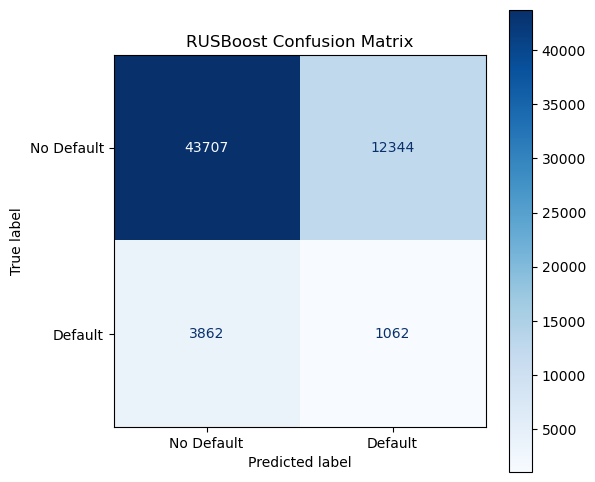

              precision    recall  f1-score   support

           0     0.9188    0.7798    0.8436     56051
           1     0.0792    0.2157    0.1159      4924

    accuracy                         0.7342     60975
   macro avg     0.4990    0.4977    0.4797     60975
weighted avg     0.8510    0.7342    0.7848     60975



In [68]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Create a base decision tree with balanced class weighting
base_rus = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=20,
    class_weight={0:1, 1:10}, # More weight to class 1 (defaulters)
    random_state=42
)

# Create a RUSBoost classifier using the base tree, combining boosting with with random undersampling
rus = RUSBoostClassifier(
    estimator=base_rus,
    n_estimators=200,
    learning_rate=0.1,
    sampling_strategy=1.0, # Equal sampling for both classes
    algorithm='SAMME.R',
    random_state=42
)

# Assign sample weights to emphasize class 1 during training
w = np.where(y_train == 1, 10, 1)
rus.fit(X_train_p, y_train, sample_weight=w)

probs_rus = rus.predict_proba(X_test_p)[:,1] # Predict probabilities for the positive class

# Search for best threshold: aim for ≥70% accuracy and maximize true positives
best_rus = {'thr':None, 'fp':np.inf, 'acc':0.0, 'cm':None}
for thr in np.linspace(0,1,501):
    preds_rus = (probs_rus >= thr).astype(int)
    acc = accuracy_score(y_test, preds_rus)
    if acc < 0.70: 
        continue
    tn, fp, fn, tp = confusion_matrix(y_test, preds_rus).ravel()
    
    # Choose threshold with highest TP, and if tie, then lowest FP
    if tp > (best_rus['cm'][3] if best_rus['cm'] else -1) or (
       tp == (best_rus['cm'][3] if best_rus['cm'] else -1) and fp < best_rus['fp']):
        best_rus.update({'thr':thr, 'fp':fp, 'acc':acc, 'cm':(tn,fp,fn,tp)})

# If no threshold satisfies the accuracy constraint, raise an error
if best_rus['thr'] is None:
    raise RuntimeError("No threshold meets 70% accuracy with RUSBoost")

# Extract the best threshold and confusion matrix components
thr = best_rus['thr']
tn, fp, fn, tp = best_rus['cm']

# Display selected threshold and associated performance metrics
print(f"➡ Chosen threshold = {thr:.3f}")
print(f"   Accuracy = {best_rus['acc']:.3f}, TP = {tp}, FP = {fp}\n")

# Construct and plot the confusion matrix
cm = np.array([[tn, fp], [fn, tp]])
disp = ConfusionMatrixDisplay(cm, display_labels=["No Default","Default"])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("RUSBoost Confusion Matrix")
plt.show()

print(classification_report(y_test, (probs_rus>=thr).astype(int), digits=4))

**ISOLATION FOREST MODEL**

This block uses Isolation Forest, an unsupervised anomaly detection algorithm, to identify loan defaulters. The model assumes that defaulters behave anomalously compared to the majority of applicants. It is trained only on features (without using the labels) and computes an anomaly score for each observation in the test set.

To determine a suitable classification threshold, a grid search is performed over 500 possible cutoff values. The goal is to find the threshold that ensures at least 75% accuracy while maximizing the true positive rate (recall on defaulters. If no threshold satisfies this constraint, an error is raised. The final results, including the selected threshold, confusion matrix, and classification metrics, are presented. This approach is useful in scenarios where labeled data is limited or where anomaly-based methods provide an alternative to supervised learning.

Chosen threshold = 0.0418
→ Accuracy = 0.7502
→ True Positives (defaults caught) = 1007
→ True Negatives (no-defaults caught) = 44737



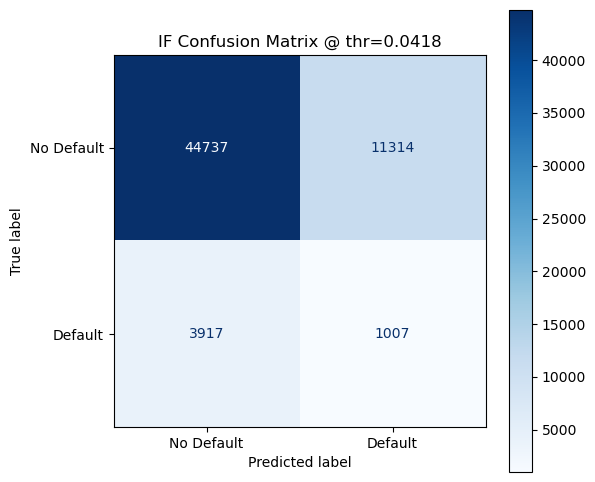

              precision    recall  f1-score   support

           0     0.9195    0.7981    0.8545     56051
           1     0.0817    0.2045    0.1168      4924

    accuracy                         0.7502     60975
   macro avg     0.5006    0.5013    0.4857     60975
weighted avg     0.8518    0.7502    0.7950     60975



In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Initialize the Isolation Forest anomaly detector
iso = IsolationForest(
    n_estimators=200,
    max_samples="auto", # Use all data points per tree
    contamination=0.05, # Assumes ~5% of data are outliers (defaults)
    random_state=42
)

# Fit the model on training data (unsupervised)
iso.fit(X_train_p)

scores = iso.decision_function(X_test_p) # Get anomaly scores on the test set (higher = more normal, lower = more anomalous)

# Search for best threshold based on accuracy ≥ 75% and highest TPR (recall on defaulters)
best_iso = {'thr':None, 'acc':0.0, 'tpr':0.0, 'cm':None}
for thr in np.linspace(scores.min(), scores.max(), 500):
    preds_iso = (scores < thr).astype(int) # Predict default if score is below threshold
    acc = accuracy_score(y_test, preds_iso)
    tn, fp, fn, tp = confusion_matrix(y_test, preds_iso).ravel()
    tpr = tp / (tp + fn) if (tp + fn)>0 else 0 # Recall on defaults
    
    # Keep threshold with highest TPR and minimum accuracy of 75%
    if acc >= 0.75 and tpr > best_iso['tpr']:
        best_iso.update({'thr':thr, 'acc':acc, 'tpr':tpr, 'cm':(tn,fp,fn,tp)})

# Raise an error if no threshold satisfies the condition
if best_iso['thr'] is None:
    raise RuntimeError("No threshold meets accuracy ≥ 0.75")

# Extract best results
thr = best_iso['thr']
tn, fp, fn, tp = best_iso['cm']

# Print final threshold and performance
print(f"Chosen threshold = {thr:.4f}")
print(f"→ Accuracy = {best_iso['acc']:.4f}")
print(f"→ True Positives (defaults caught) = {tp}")
print(f"→ True Negatives (no-defaults caught) = {tn}\n")

# Create and show confusion matrix
cm = np.array([[tn, fp], [fn, tp]])
disp = ConfusionMatrixDisplay(cm, display_labels=["No Default","Default"])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title(f"IF Confusion Matrix @ thr={thr:.4f}")
plt.show()

print(classification_report(y_test, (scores<thr).astype(int), digits=4)) # Print precision, recall, and F1-score report

**DUAL AUTOENCODER (MLP) MODEL**

This approach trains two separate autoencoders: one on non-defaulters and another on defaulters. The defaulter data is upsampled to match the size of the non-defaulter set, ensuring balanced training. Each autoencoder learns to reconstruct the feature distribution of its respective class using a symmetric neural network structure with a bottleneck. During testing, both autoencoders attempt to reconstruct every test instance. The mean squared reconstruction error (MSE) is calculated for each. If the defaulter-trained autoencoder achieves lower MSE than the non-defaulter one, the sample is classified as a defaulter — suggesting it is more similar to the defaulter profile.

This dual-model comparison helps separate borrowers who behave anomalously compared to the majority class. The final performance is presented using a confusion matrix and classification report. This method is useful when class separation is more evident in feature space than in linear decision boundaries.

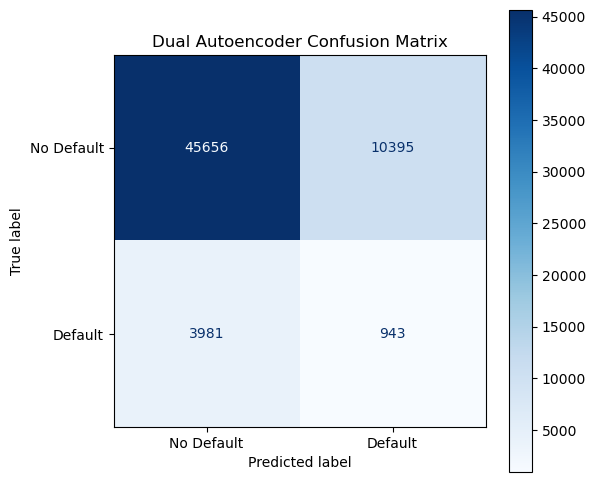

              precision    recall  f1-score   support

           0     0.9198    0.8145    0.8640     56051
           1     0.0832    0.1915    0.1160      4924

    accuracy                         0.7642     60975
   macro avg     0.5015    0.5030    0.4900     60975
weighted avg     0.8522    0.7642    0.8036     60975



In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Split training data into defaulters and non-defaulters
X_nondef = X_train_p[y_train == 0]
X_def    = X_train_p[y_train == 1]

# Upsample defaulters to match the number of non-defaulters
X_def_res = resample(
    X_def,
    replace=True,
    n_samples=len(X_nondef),
    random_state=42
)

# Define function to create a multi-layer perceptron autoencoder
def make_ae():
    return MLPRegressor(
        hidden_layer_sizes=(64, 16, 64), # Encoder–bottleneck–decoder architecture
        activation='relu',
        solver='adam',
        max_iter=200,
        random_state=42
    )

# Initialize two autoencoders: one for non-defaulters, one for defaulters
ae_nondef = make_ae()
ae_def    = make_ae()

# Train each autoencoder to reconstruct only its respective class
ae_nondef.fit(X_nondef, X_nondef)
ae_def   .fit(X_def_res,  X_def_res)

# Get reconstruction outputs for the test set from both autoencoders
X_test_arr = X_test_p
rec0 = ae_nondef.predict(X_test_arr) # Reconstruction by non-defaulter AE
rec1 = ae_def   .predict(X_test_arr) # Reconstruction by defaulter AE

# Calculate mean squared error (MSE) for each reconstruction
mse0 = np.mean((X_test_arr - rec0) ** 2, axis=1)
mse1 = np.mean((X_test_arr - rec1) ** 2, axis=1)

y_pred_ae = np.where(mse1 < mse0, 1, 0) # Classify as defaulter (1) if defaulter autoencoder performs better (lower error)

# Display confusion matrix
cm_ae = confusion_matrix(y_test, y_pred_ae)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ae, display_labels=["No Default","Default"])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Dual Autoencoder Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_ae, digits=4))

**BALANCED RANDOM FOREST MODEL**

This section trains a Balanced Random Forest classifier, a variant of the random forest that automatically balances class weights by undersampling the majority class during each bootstrap sample. This is especially useful in imbalanced classification scenarios such as default prediction. After predicting probabilities on the test set, a custom threshold search is performed. The goal is to identify a cutoff that provides at least 75% accuracy while maximizing recall on defaulters (Recall₁ and ensuring at least one true positive (TP > 0).

Once the best threshold is found, it is applied to convert probabilities into class predictions. A confusion matrix and full classification report are displayed to evaluate the model’s performance. This approach combines interpretability and robustness, making it suitable for risk-sensitive applications where both false positives and false negatives must be controlled.

Chosen threshold = 0.442
→ Accuracy = 0.751, Recall₁ = 0.203
→ TN = 44802, FP = 11249, FN = 3922, TP = 1002



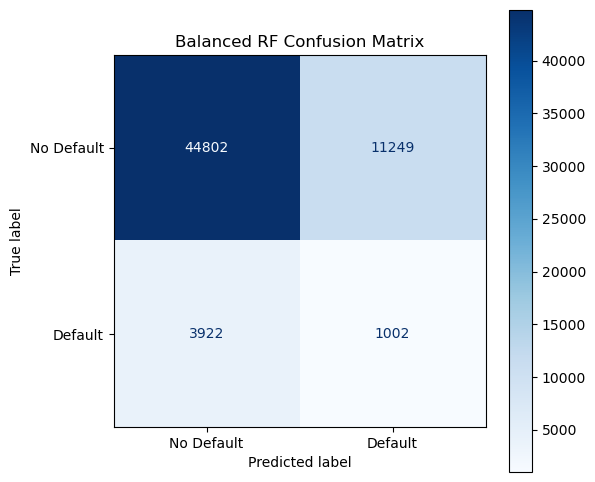

              precision    recall  f1-score   support

           0     0.9195    0.7993    0.8552     56051
           1     0.0818    0.2035    0.1167      4924

    accuracy                         0.7512     60975
   macro avg     0.5006    0.5014    0.4859     60975
weighted avg     0.8519    0.7512    0.7956     60975



In [80]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Initialize a Balanced Random Forest (handles class imbalance internally)
brf = BalancedRandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

brf.fit(X_train_p, y_train) # Fit the model on the training data

probs_brf = brf.predict_proba(X_test_p)[:,1] # Get predicted probabilities for class 1 (defaulter)

best_brf = {"thr": None, "acc": 0.0, "rec1": 0.0, "cm": None} # Initialize tracking dictionary for best threshold

# Search thresholds from 0 to 1 to maximize recall₁ while maintaining ≥75% accuracy
for thr in np.linspace(0, 1, 501):
    preds_brf = (probs_brf >= thr).astype(int)
    acc = accuracy_score(y_test, preds_brf)
    tn, fp, fn, tp = confusion_matrix(y_test, preds_brf).ravel()
    rec1 = tp / (tp + fn) if (tp + fn)>0 else 0

    # Keep thresholds that meet accuracy and improve recall
    if acc >= 0.75 and tp > 0 and rec1 > best_brf["rec1"]:
        best_brf.update({"thr": thr, "acc": acc, "rec1": rec1, "cm": (tn, fp, fn, tp)})

# Error if no threshold meets criteria
if best_brf["thr"] is None:
    raise RuntimeError("No threshold meets ≥75% accuracy with TP>0")

# Unpack best results
thr = best_brf["thr"]
tn, fp, fn, tp = best_brf["cm"]

# Print chosen threshold and performance
print(f"Chosen threshold = {thr:.3f}")
print(f"→ Accuracy = {best_brf['acc']:.3f}, Recall₁ = {best_brf['rec1']:.3f}")
print(f"→ TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}\n")

# Plot confusion matrix
cm_brf = np.array([[tn, fp], [fn, tp]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_brf, display_labels=["No Default","Default"])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Balanced RF Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_test, (probs_brf >= thr).astype(int), digits=4))